# EEG data examples

Here, we demonstrate `sbijax` using a complicated real world EEG data set. We first load some required libraries and an EEG dataset.

We will take EEG measurements when subjects have their eyes closed or open, respectively, and compute posterior distributions of relevant parameters for each measurement to detect a difference in distributions between the two.

In [7]:
import os
import arviz as az
import jax
import numpy as np
import optax
import sbijax
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd

In [8]:
import mne
import moabb
import jrnmm

from jax.scipy.signal import welch
from moabb.datasets import Rodrigues2017

## EEG data

The data set can be readily downloaded using the `moabb` package and preprocessed using the EEG analysis tool `mne`.

In [9]:
import tempfile
temp_dir = tempfile.TemporaryDirectory()
print(temp_dir)

<TemporaryDirectory '/var/folders/w8/7mc8k9m916qgh982xqxfgsr00000gn/T/tmpsyxwbzp4'>


In [10]:
dataset = Rodrigues2017()
dataset.download(path=temp_dir.name, verbose=False)

Following previous work (the our manuscript for more information), we filter the data at 3Hz and 40Hz and resample them.

In [11]:
raw = dataset._get_single_subject_data(subject=2)['0']['0']
raw = raw.filter(l_freq=3, h_freq=40, verbose=False)
raw = raw.resample(sfreq=128, verbose=False)

We then extract the EEG recordings from the Oz channel and visualize the data.

In [12]:
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=8.0, baseline=None, verbose=False)
epochs = epochs.load_data().pick_channels(['Oz'])

Using data from preloaded Raw for 10 events and 1025 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [13]:
X_closed = epochs['closed'].get_data().squeeze()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_closed_db = 10 * np.log10(S_closed)

X_opened = epochs['open'].get_data().squeeze()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_opened_db = 10 * np.log10(S_opened)

In [14]:
if not os.path.exists("figs"):
    os.mkdir("figs")

To compute posterior distributions later, we randomly select one sample from the closed-eyes EEGs and one from the open-eyes EEGs.

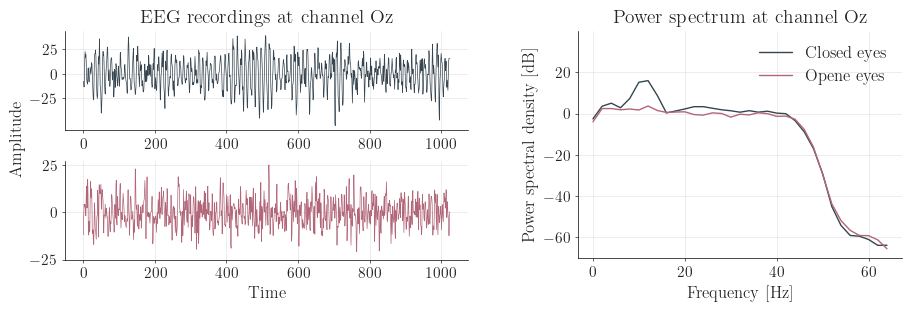

In [15]:
fig = plt.figure(layout="constrained", figsize=(9, 3))
subfigs = fig.subfigures(1, 2, wspace=.1, width_ratios=[1.2, 1])
with plt.style.context("sbijax"):        
    laxes = subfigs[0].subplots(2, 1)    
    laxes[0].set_title("EEG recordings at channel Oz", fontsize=14)
    laxes[0].plot(X_closed[2, :], color="#36454F", label="closed", linewidth=.5)
    laxes[1].plot(X_opened[2, :], color="#b26679", label="opened", linewidth=.5)            
    laxes[0].yaxis.set_ticks([-25, 0, 25])
    laxes[1].yaxis.set_ticks([-25, 0, 25])
    laxes[0].grid(linewidth=0.5)
    laxes[1].grid(linewidth=0.5)
    laxes[0].spines['bottom'].set_color('black')    
    laxes[1].spines['bottom'].set_color('black')
    laxes[0].spines['left'].set_color('black')
    laxes[1].spines['left'].set_color('black')
    laxes[1].set_xlabel("Time", fontsize=12)
    laxes[0].set_ylabel("Amplitude", fontsize=12)
    laxes[0].yaxis.set_label_coords(-0.1, -0.1)

    raxes = subfigs[1].subplots(1, 1)
    raxes.set_title("Power spectrum at channel Oz", fontsize=14)
    raxes.plot(f, S_closed_db[2], color='#36454F', lw=1, label="Closed eyes")
    raxes.plot(f, S_opened_db[2], color='#b26679', lw=1, label="Opene eyes")    
    raxes.yaxis.set_ticks([-60, -40, -20, 0, 20])
    raxes.set_ylim(-70, 40)
    raxes.spines['bottom'].set_color('black')
    raxes.spines['left'].set_color('black')
    raxes.set_xlabel("Frequency [Hz]", fontsize=12)
    raxes.set_ylabel("Power spectral density [dB]", fontsize=12)
    raxes.legend(frameon=False, fontsize=12)
    raxes.grid(linewidth=0.5)
plt.savefig("figs/real_data-data.pdf", dpi=200)
plt.show()

For completeness, we plot the entire data set, too.

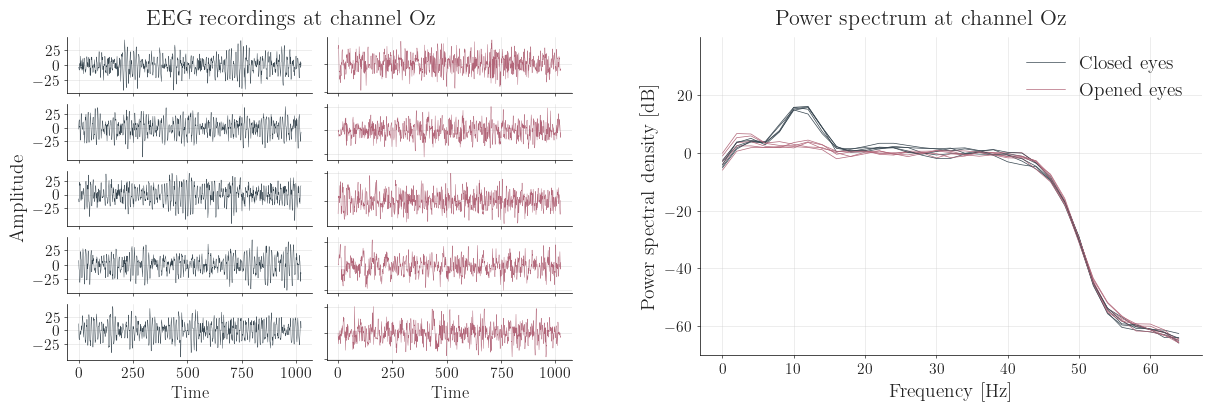

In [16]:
fig = plt.figure(layout="constrained", figsize=(12, 4))
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=[1.5, 1.5])
with plt.style.context("sbijax"):
    subfigs[0].suptitle("EEG recordings at channel Oz", fontsize=16)
    subfigs[1].suptitle("Power spectrum at channel Oz", fontsize=16)
    laxes = subfigs[0].subplots(5, 2)    
    for i in range(5):
        laxes[i, 0].plot(X_closed[i, :], color="#36454F", label="closed", linewidth=.31)
        laxes[i, 1].plot(X_opened[i, :], color="#b26679", label="opened", linewidth=.31)        
        if i != 4:
            laxes[i, 0].xaxis.set_ticklabels([])            
            laxes[i, 1].xaxis.set_ticklabels([]) 
        laxes[i, 0].yaxis.set_ticks([-25, 0, 25])
        laxes[i, 1].yaxis.set_ticklabels([])     
        laxes[i, 0].grid(linewidth=0.5)
        laxes[i, 1].grid(linewidth=0.5)
        laxes[i, 0].spines['bottom'].set_color('black')
        laxes[i, 0].spines['left'].set_color('black')
        laxes[i, 1].spines['bottom'].set_color('black')
        laxes[i, 1].spines['left'].set_color('black')
    laxes[2, 0].set_ylabel("Amplitude", fontsize=14)
    laxes[4, 0].set_xlabel("Time", fontsize=12)
    laxes[4, 1].set_xlabel("Time", fontsize=12)
    
    raxes = subfigs[1].subplots(1, 1)
    for i in range(5):
        if i ==0:
            raxes.plot(f, S_closed_db[i], color='#36454F', lw=.5, label="Closed eyes")
            raxes.plot(f, S_opened_db[i], color='#b26679', lw=.5, label="Opened eyes")
        else:
            raxes.plot(f, S_closed_db[i], color='#36454F', lw=.5)
            raxes.plot(f, S_opened_db[i], color='#b26679', lw=.5)
    raxes.yaxis.set_ticks([-60, -40, -20, 0, 20])
    raxes.set_ylim(-70, 40)
    raxes.spines['bottom'].set_color('black')
    raxes.spines['left'].set_color('black')
    raxes.set_ylabel("Power spectral density [dB]", fontsize=14)
    raxes.set_xlabel("Frequency [Hz]", fontsize=14)
    raxes.legend(frameon=False, fontsize=14)
    raxes.grid(linewidth=0.5)
plt.savefig("figs/real_data-all_data.pdf", dpi=200)
plt.show()

## Prior and simulator

We next set up the prior and simulator. For the simulator, we use the [jrnmm](https://github.com/dirmeier/jrnmm) package which neatly implements the Jansen-Rit SDE.

In [17]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        C=tfd.Uniform(10.0, 250.0),
        mu=tfd.Uniform(50.0, 500.0),
        sigma=tfd.Uniform(100, 5000),
        gain=tfd.Uniform(-20, 20),
    ), batch_ndims=0)
    return prior

prior = prior_fn()

In [18]:
def jansen_rit_fn(len_timeseries=1025, t_end=8.0):        
    # sampling rate is 1/F where F=128
    dt = 1 / 128

    def fn(seed, Cs, mus, sigmas, gains):        
        initial_states = jnp.array([0.08, 18, 15, -0.5, 0, 0])
        yt = jrnmm.simulate(seed, dt, t_end + dt, initial_states, Cs=Cs, mus=mus, sigmas=sigmas, gains=gains)   
        return yt - yt.mean(axis=1).reshape(-1, 1, 1)

    return fn

simulate_jansen_rit = jansen_rit_fn(len_timeseries=1025, t_end=8.0)

We then construct a simulator suitable for `sbijax`.

In [19]:
def simulator(seed, theta, len_timeseries=1025, t_end=8.0, batch_size=200):        
    Cs, mus, sigmas, gains = theta["C"], theta["mu"], theta["sigma"], theta["gain"]    
    n_theta = len(Cs)
    n_iter = (n_theta // batch_size) + int(np.ceil((n_theta % batch_size) / batch_size))
    ys = []    
    for idx in range(n_iter):
        idxs = slice((batch_size * idx), (batch_size * (idx + 1)))        
        rng_key, seed = jr.split(seed)
        y = simulate_jansen_rit(rng_key, Cs[idxs], mus[idxs], sigmas[idxs], gains[idxs])        
        ys.append(y)
    ys = jnp.squeeze(jnp.vstack(ys))    
    return ys

In a final step before inferring the posteriors, we simulate 100000 synthetic trajectories. We save them, a reference trjectory for testing, and the real data as a pickle file in order to avoid lengthy computations.

In [20]:
def get_experimental_data(prior):
    import pickle

    fl = "./eeg_data.pkl"
    if os.path.exists(fl):
        print("loading precomputed data")
        with open(fl, 'rb') as handle:
            di = pickle.load(handle)
        return di

    # synthetic data example
    theta_synthetic = [135, 220, 2000, 0]
    y_synthetic = simulate_jansen_rit(jr.PRNGKey(1), *theta_synthetic)
    y_synthetic = np.array(y_synthetic)

    # experimental data
    y_experimental_closed = X_closed[[2]]
    y_experimental_opened = X_opened[[2]]    

    # simulations
    n = 100_000
    theta_train = prior.sample(seed=jr.PRNGKey(2), sample_shape=(n,))
    y_train = simulator(jr.PRNGKey(3), theta_train)
    with open(fl, 'wb') as handle:
        di = dict(
            theta_synthetic=theta_synthetic, 
            y_synthetic=y_synthetic, 
            y_experimental_closed=y_experimental_closed, 
            y_experimental_opened=y_experimental_opened,
            theta_train=theta_train, 
            y_train=y_train
        )        
        pickle.dump(
            di, 
            handle, 
            protocol=pickle.HIGHEST_PROTOCOL
        )
    
    return di

eeg_data = get_experimental_data(prior)

# Summary statistics

As described in the manuscript, we do inference on a collection of summary statistics for which we take the spectral density evaluated at several bins instead of the entire time series.

In [21]:
def summarize(y, n_summaries=33, fs=epochs.info['sfreq']):
    _, summaries = welch(y, fs=fs, nperseg=2 * (n_summaries - 1), axis=1)
    return summaries

In [22]:
summaries_train = summarize(eeg_data["y_train"])

# Neural posterior estimation

We now do posterior inference. We choose to use neural posterior estimation here, but any other method implemented in `sbijax` would also work. 
Neural posterior, however, has the advantage that we only have to model a four-dimensional space (i.e., the dimensionality of the posterior) and not the data space, which makes it efficient in this scenario.

We train in an amortized fashion such that we can compute posteriors for multiple observations (i.e., closed vs opened eyes).

Notice that we do not provide the simulator function here. Since we train in an amortized fashion and already have a set of simulated samples, the simulator is not needed here.
In many inferential problems in the natural sciences it is common that new data _cannot_ be simulated, but a batch of previously simulated samples is available. `sbijax` supports this scenario like this as shown below.

In [23]:
from sbijax import NPE
from sbijax.nn import make_maf

In [30]:
n_dim_data = 33 # number of summary statistics from prior literature
n_dim_theta = 4 # posterior dimensionality
n_layers, hidden_sizes = 10, (64, 64)
neural_network = make_maf(n_dim_theta, n_layers, hidden_sizes=hidden_sizes)

fns = prior_fn, None
estim = NPE(fns, neural_network)

We use the summaries and parameter values as training data.

In [31]:
data = {"y": summaries_train, "theta": eeg_data["theta_train"]}
params, info = estim.fit(
    jr.PRNGKey(1),
    data=data,
    optimizer=optax.adam(0.0001),
    n_early_stopping_delta=0.00001,
    n_early_stopping_patience=30,    
)

 53%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 528/1000 [25:23<22:41,  2.88s/it]


# Synthetic data example

We evaluate first if we are able to approximately infer the true parameter values for a synthetic samples.

In [33]:
posterior, diagnostics = estim.sample_posterior(
    jr.PRNGKey(1), 
    params,
    observable=summarize(eeg_data["y_synthetic"].reshape(1, -1)),    
    n_samples=10_000
)

In [34]:
eeg_data["theta_synthetic"]

[135, 220, 2000, 0]

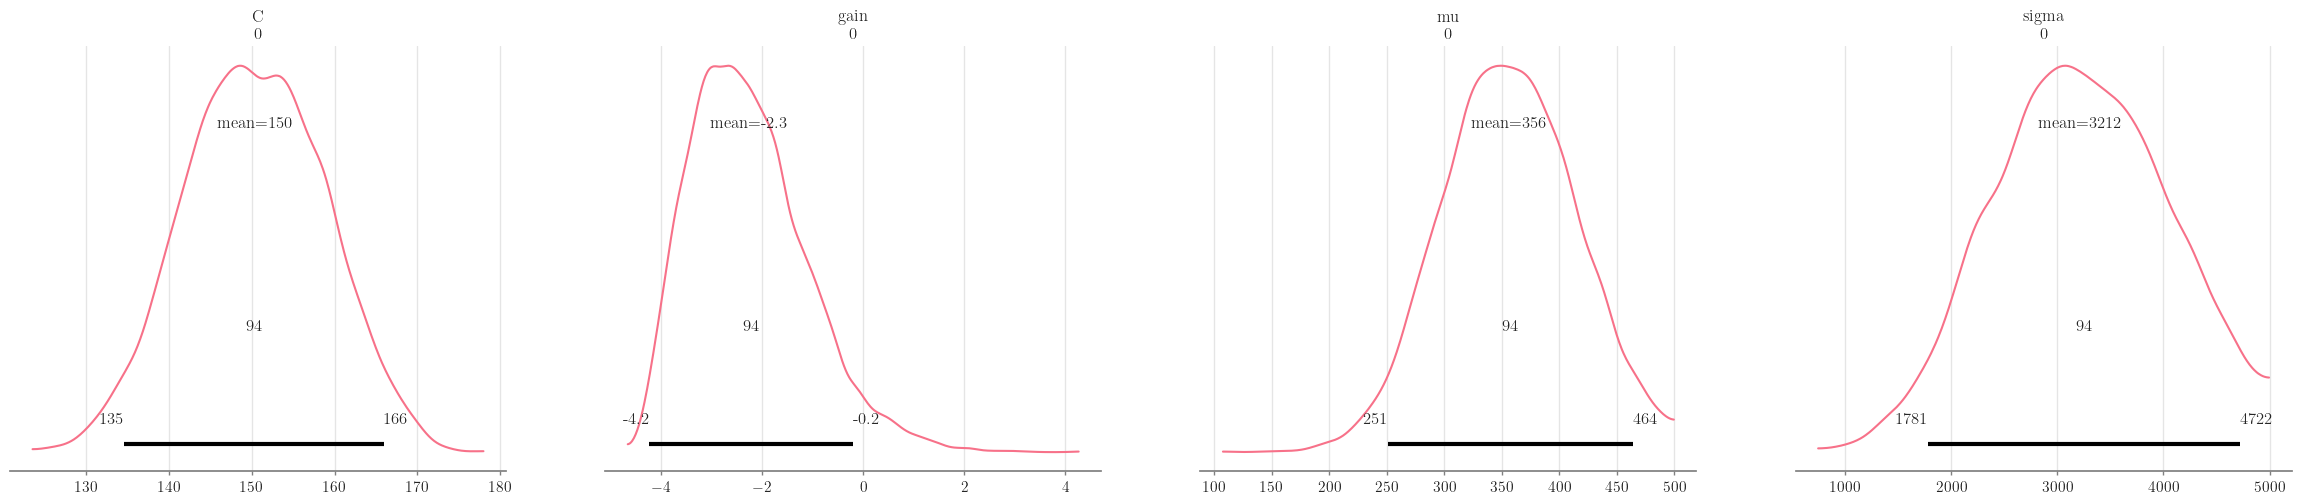

In [35]:
az.plot_posterior(posterior)
plt.show()

## Inference of posterior distributions for closed and opened eyes EEG data

In [ ]:
def plot_posteriors(obj):
    _, axes = plt.subplots(figsize=(12, 10), nrows=5, ncols=5)
    with az.style.context(["arviz-doc"], after_reset=True):
        for i in range(0, 5):
            for j in range(0, 5):
                ax = axes[i, j]
                if i < j:
                    ax.axis('off')
                else:
                    ax.hexbin(obj[..., j], obj[..., i], gridsize=50, bins='log', cmap='viridis')
                ax.spines.left.set_linewidth(.5)
                ax.spines.bottom.set_linewidth(.5)
                ax.spines.right.set_linewidth(.5)
                ax.spines.top.set_linewidth(.5)
                ax.xaxis.set_major_locator(MaxNLocator(2))
                ax.yaxis.set_major_locator(MaxNLocator(2))
                ax.xaxis.set_tick_params(width=1, length=2, labelsize=25)
                ax.yaxis.set_tick_params(width=1, length=2, labelsize=25)
                if i < 4:
                    ax.set_xticklabels([])
                    ax.xaxis.set_tick_params(width=0., length=0)
                if j != 0:
                    ax.set_yticklabels([])
                    ax.yaxis.set_tick_params(width=0., length=0)
                ax.grid(which='major', axis='both', alpha=0.5)
        for i in range(5):
            axes[i, i].hist(obj[..., i], color="black")
    return axes

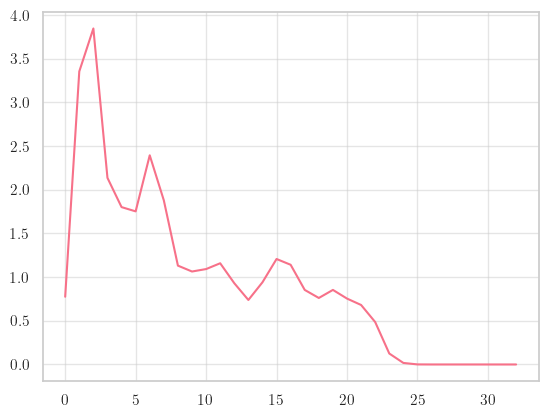

In [55]:
plt.plot(summarize(X_opened)[4])

In [62]:
posterior_open, diagnostics = estim.sample_posterior(
    jr.PRNGKey(2), 
    params,
    observable=summarize(X_opened)[4],
    n_samples=100,
)

KeyboardInterrupt: 

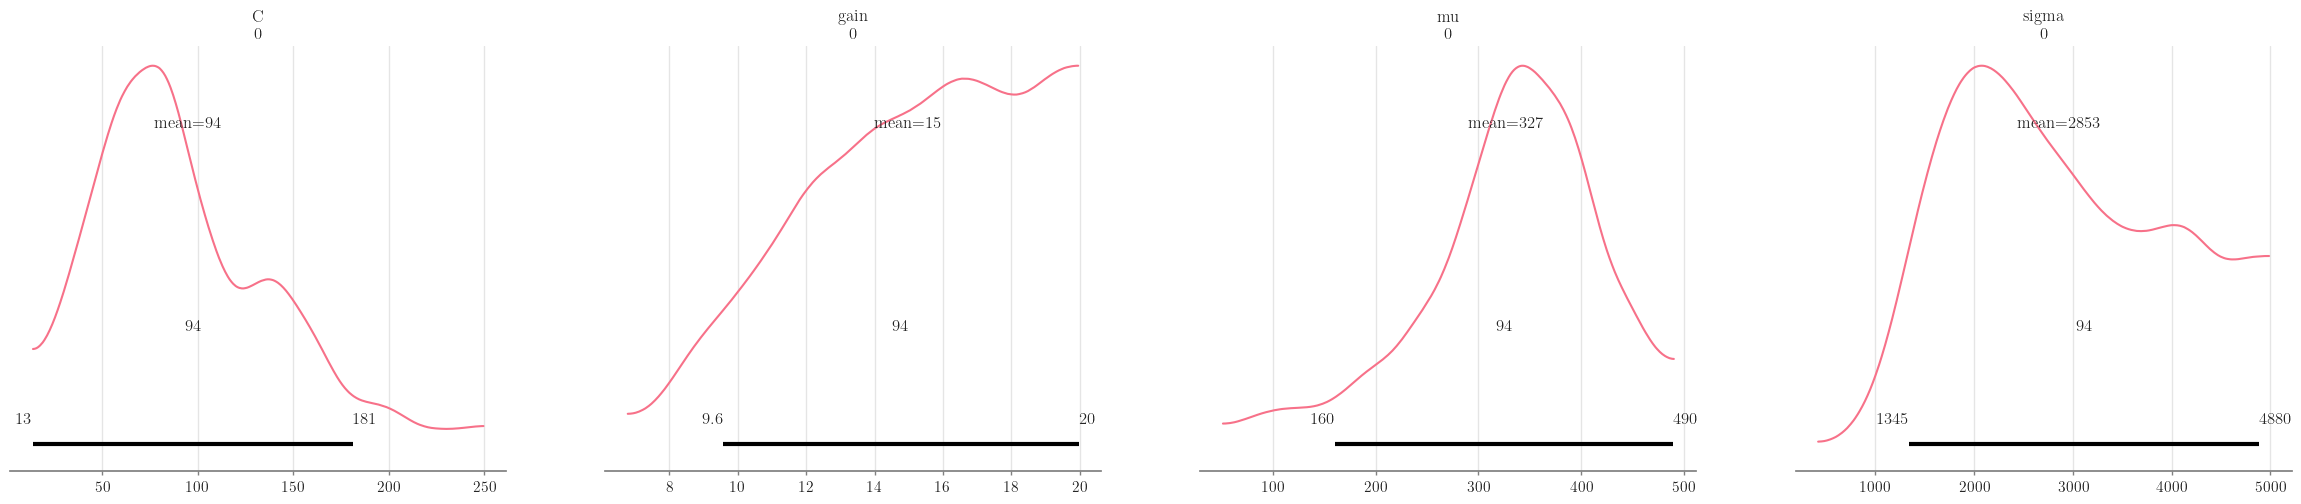

In [51]:
az.plot_posterior(posterior_open)
plt.show()

In [40]:
posterior_closed, diagnostics = estim.sample_posterior(
    jr.PRNGKey(2),
    params,
    observable=summarize(eeg_data["y_experimental_closed"]),    
    n_samples=100,    
)

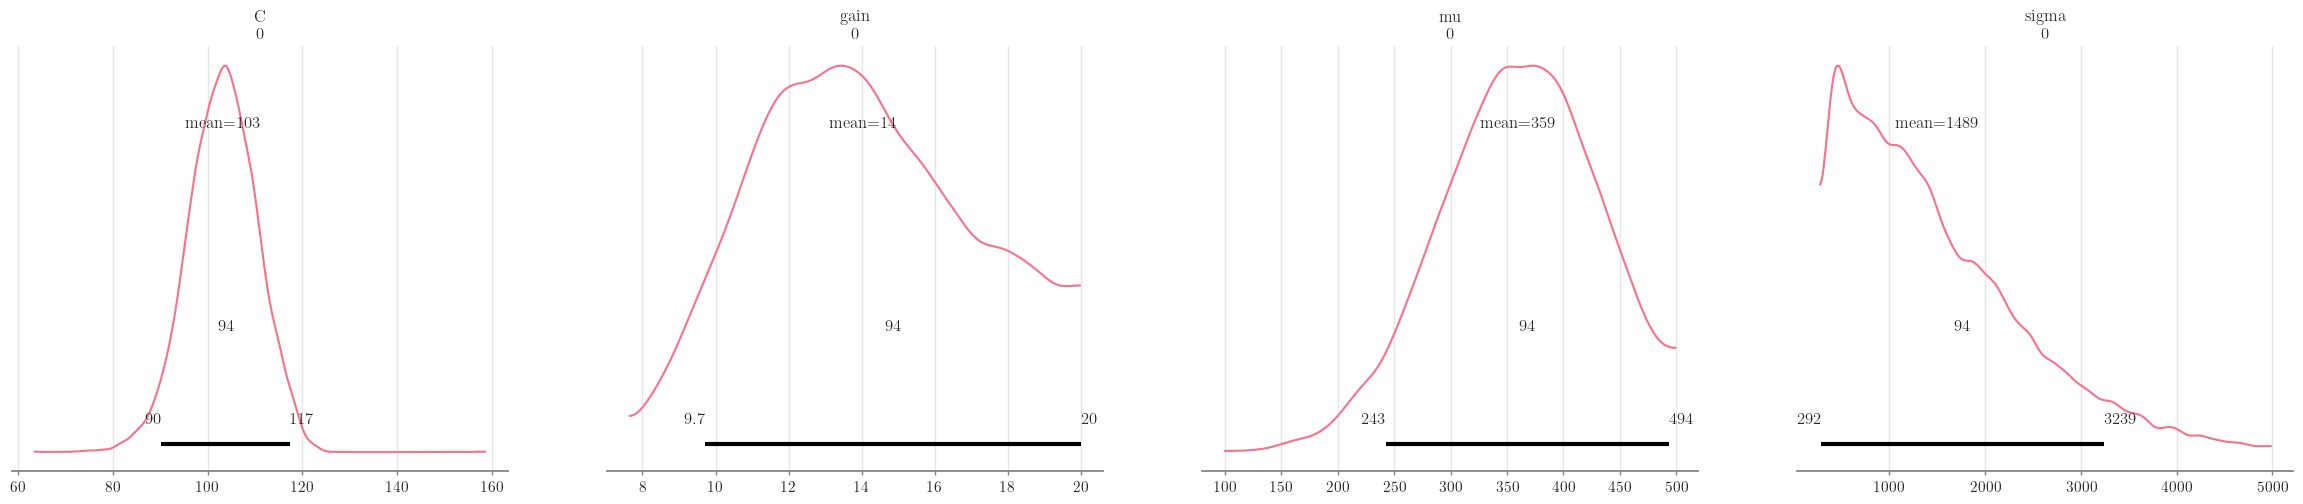

In [53]:
az.plot_posterior(posterior_closed)
plt.show()

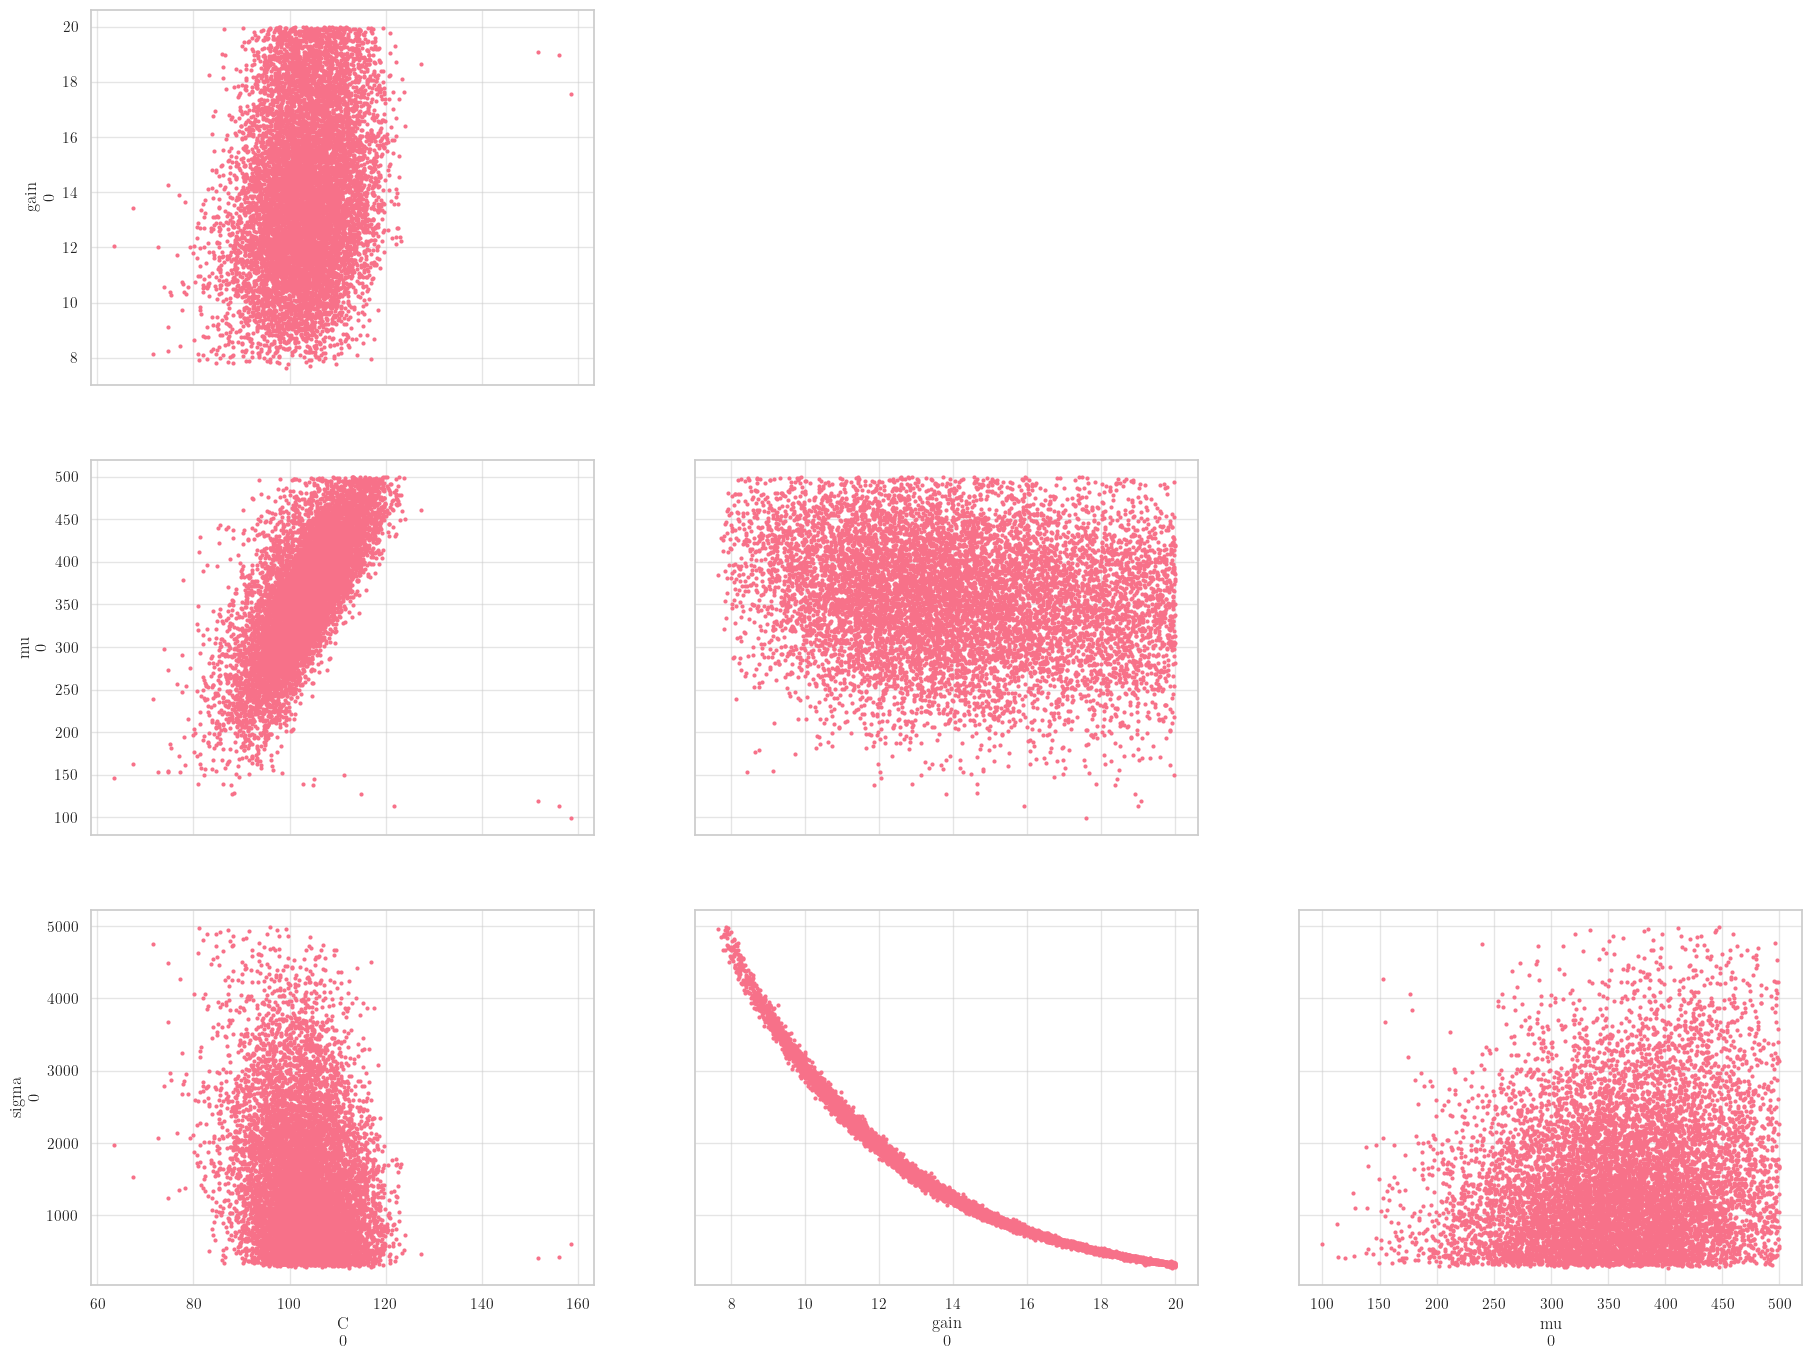

In [56]:
az.plot_pair(posterior_closed)
plt.show()

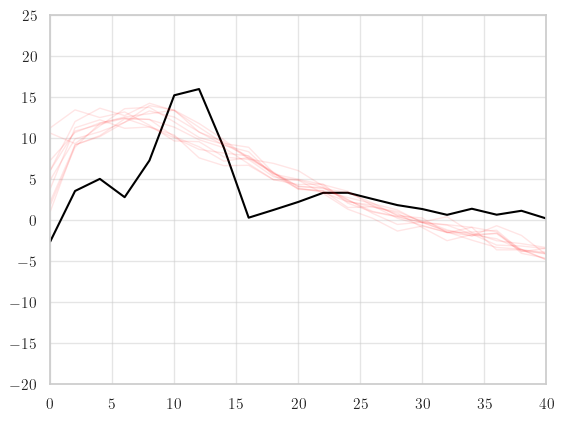

In [122]:
f, s = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
s = 10 * np.log10(s)
plt.plot(f, s[2], color="black")
sss = 10 * np.log10(summarize(ppd))
for i in range(10):
   plt.plot(f, sss[i], color="red", linewidth=1, alpha=.1)
plt.ylim(-20, +25)
plt.xlim(0, 40)
plt.show()

In [ ]:
## Session info

In [ ]:
import session_info

session_info.show(html=False)